In [13]:
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

['/device:CPU:0', '/device:GPU:0']


In [14]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, MaxPooling2D
from keras.layers.convolutional import Conv2D 
from keras.utils import np_utils
from keras import backend as K

from distutils.version import LooseVersion as LV
from keras import __version__

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

import numpy as np
from sklearn.preprocessing import normalize
from keras.models import model_from_json

import random
from keract import get_activations, display_activations

import tensorflow as tf
from tensorflow import norm, Session
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn import linear_model
print('Using Keras version:', __version__, 'backend:', K.backend())
assert(LV(__version__) >= LV("2.0.0"))

Using Keras version: 2.2.4 backend: tensorflow


In [15]:
# Creates a graph.
a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
c = tf.matmul(a, b)
# Creates a session with log_device_placement set to True.
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
# Runs the op.
print(sess.run(c))

[[22. 28.]
 [49. 64.]]


In [16]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

nb_classes = 10

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

# one-hot encoding:
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

print()
print('MNIST data loaded: train:',len(X_train),'test:',len(X_test))
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('Y_train:', Y_train.shape)


MNIST data loaded: train: 60000 test: 10000
X_train: (60000, 28, 28)
y_train: (60000,)
Y_train: (60000, 10)


In [17]:
# input image dimensions
img_rows, img_cols = 28, 28

if K.image_dim_ordering() == 'th':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    
print('X_train:', X_train.shape)

X_train: (60000, 28, 28, 1)


In [18]:
# number of convolutional filters to use
nb_filters = 128
# convolution kernel size
kernel_size = (3, 3)
# size of pooling area for max pooling
pool_size = (2, 2)

model = Sequential()

model.add(Conv2D(nb_filters, kernel_size,
                 padding='same',
                 activation='relu',
                 input_shape=input_shape))

model.add(Conv2D(nb_filters, kernel_size,
                 padding='same',
                 activation='relu'))


model.add(Conv2D(nb_filters, kernel_size,
                 padding='same',
                 activation='relu'))
model.add(Conv2D(nb_filters, kernel_size,
                 padding='same',
                 activation='relu'))
model.add(Conv2D(nb_filters, kernel_size,
                 padding='same',
                 activation='relu'))


model.add(Flatten())
model.add(Dense(128, activation = 'relu'))#model.add(Dropout(0.5))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes , activation = 'softmax'))


model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 28, 28, 128)       1280      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 128)       147584    
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 128)       147584    
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 28, 28, 128)       147584    
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 28, 28, 128)       147584    
_________________________________________________________________
flatten_2 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               12845184  
__________

In [19]:
%time

epochs = 5 # one epoch takes about 45 seconds

history = model.fit(X_train, 
                    Y_train, 
                    epochs=epochs, 
                    batch_size=128,
                    verbose=2)





CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.91 µs
Epoch 1/5
 - 14s - loss: 0.2743 - acc: 0.9218
Epoch 2/5
 - 10s - loss: 0.0614 - acc: 0.9835
Epoch 3/5
 - 10s - loss: 0.0423 - acc: 0.9891
Epoch 4/5
 - 10s - loss: 0.0308 - acc: 0.9920
Epoch 5/5
 - 10s - loss: 0.0249 - acc: 0.9933


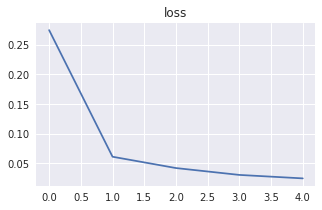

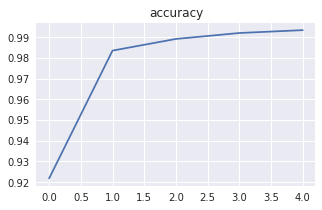

In [20]:
plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['loss'])
plt.title('loss')

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['acc'])
plt.title('accuracy');

In [21]:
%%time
scores = model.evaluate(X_test, Y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))



# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

acc: 99.19%
Saved model to disk
CPU times: user 1.01 s, sys: 372 ms, total: 1.38 s
Wall time: 1.28 s


In [22]:
##### Load the model
#
#with open('model.json','r') as f:
#    json = f.read()
#loaded_model = model_from_json(json)

#loaded_model.load_weights("model.h5")

#loaded_model.compile(loss='categorical_crossentropy',
#              optimizer='rmsprop',
#              metrics=['accuracy'])

#scores = loaded_model.evaluate(X_test, Y_test, verbose=2)
#print("%s: %.2f%%" % (loaded_model.metrics_names[1], scores[1]*100))

#model=loaded_model


In [ ]:
#from keract import get_activations, display_activations


def print_names_and_shapes(activations):  # dict
    for layer_name, layer_activations in activations.items():
        print(layer_name)
        print(layer_activations.shape)
        print('')


def print_names_and_values(activations):  # dict
    for layer_name, layer_activations in activations.items():
        print(layer_name)
        print(layer_activations)
        print('')




#print_names_and_shapes(activations)
#display_activations(activations)


###get number of total conv_filters###
total_filters = nb_filters*5
#for layer_name, layer_activations in activations.items():
#    if( layer_name.startswith('conv') ):
#        total_filters += layer_activations.shape[3] 


###response matrix X : (example * filters)###       
image_responses = np.empty((60000 ,total_filters))
init_row = 0

for i in range(30):
    print(i)
    activations = get_activations(model, X_train[init_row:init_row+2000,:,:])
    init = 0
    for layer_name, layer_activations in activations.items():
        #print(layer_name)
        if( layer_name.startswith('conv') ):
            num_filters = layer_activations.shape[3]
            with tf.Session() as sess:        
                ###L2 norms of filter responses###
                layer_activations = tf.norm(layer_activations, ord =2, axis=2)
                layer_activations = tf.norm(layer_activations, ord=2, axis=1)
                result = sess.run(layer_activations)

                ###L1 normalize layer wise###
                layer_activations_normalized = normalize(result, axis=1, norm='l1')

                #print(layer_activations_normalized)
                upper_limit = init + num_filters
                image_responses[init_row:init_row+2000, init:upper_limit] = layer_activations_normalized
                init += num_filters
    init_row+= 2000
    
        
print(image_responses.shape)        
        
###norm sanity check###
#layer_acts2 = activations["conv2d_1/Relu:0"]
#act0 = layer_acts2[0,:,:,1]
#print(np.linalg.norm(act0))
#plt.imshow(act0.reshape(28,28))

0


In [ ]:
from spgl1 import spgl1, spg_lasso, spgSetParms

# % -----------------------------------------------------------
    # % Solve LASSO problem for ||x||_1 <= tau
    # 
    #   argminW ||XW-L||_2 subject to ||x||_1 <= tau.
    # 
    #    Where 
    #        X: (example * filters) matrix
    #        W: (filter * class) matrix
    #        L: (example * class) matrix
    #
    # % ----------------------------------------------------------


#L = Y_train[:10000,:]
#clf = linear_model.Lasso(alpha=0.00001, normalize=False)
#clf.fit(image_responses,L)
#W = clf.coef_
#print(W)
#np.savetxt("sparse_features.csv", W, delimiter=",")



X_t = image_responses
L_t = Y_train[:, :]

print("x.t shape", X_t.shape)
print("l.t shape", L_t.shape)

W_opt = np.empty((X_t.shape[1], L_t.shape[1]))

w = np.empty((X_t.shape[1],))

for i in range(W_opt.shape[1]):
    b = L_t[:,i]
    tau = 10
    w ,resid,grad,info = spg_lasso(X_t, b, tau)
    W_opt[:,i] = w
    
    
print(W_opt)
print(W_opt.shape)

W = W_opt.T




In [ ]:
##ONLY CONV

# load json and create model

##### Load the model

with open('model.json','r') as f:
    json = f.read()
loaded_model = model_from_json(json)

loaded_model.load_weights("model.h5")



z = np.zeros((3,3))
def only_conv(model):
    init = 0
    for layer in model.layers:
        if( layer.name.startswith('conv') ):
            print(layer.name)

            layer_weights = layer.get_weights()
            layer_weights_copy = layer.get_weights()

            num_filters = layer.get_weights()[0].shape[3]
            upper_limit = init + num_filters

            W_layer = W[:, init:upper_limit]
            nonzero = np.nonzero(W_layer)
         
            dropped_filters = list(set(nonzero[1]))
            print(dropped_filters)
            print("Number of filters dropped: ", len(dropped_filters))
            
            #print(z.shape)
            for filt in dropped_filters:
                #print(filt)
                layer_weights_copy[0][:,:,0,filt] = 0
                layer_weights_copy[1][filt] = 0 
            #for i in range(31):
            #    print(layer_weights_copy[1])

            layer.set_weights(layer_weights_copy)
            init += num_filters
            #print(layer_weights_copy)
only_conv(loaded_model)
  





In [ ]:
loaded_model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

scores = loaded_model.evaluate(X_test, Y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

In [ ]:

#RANDOM CONV NO AMOUNT CONTROL

##### Load the model

with open('model.json','r') as f:
    json = f.read()
loaded_model = model_from_json(json)

loaded_model.load_weights("model.h5")




#z = np.zeros((3,3))
def only_conv_random(model):
    init = 0
    for layer in model.layers:
        if( layer.name.startswith('conv') ):
            print(layer.name)
            #print(layer.get_weights()[0].shape)

            layer_weights = layer.get_weights()
            layer_weights_copy = layer.get_weights()

            num_filters = layer.get_weights()[0].shape[3]
            upper_limit = init + num_filters

            num_drop_filters = np.random.randint(0, high=num_filters)
       
            dropped_filters = np.random.randint(0, high=num_filters, size=(num_drop_filters,))
          
            dropped_filters = list(set(dropped_filters))
            print(dropped_filters)
            print("Number of filters dropped: ", len(dropped_filters))
            z = np.zeros(layer_weights_copy[0][:,:,0,0].shape)

            for filt in range(0, 83): 
                layer_weights_copy[0][:,:,0,filt] = 0
                layer_weights_copy[1][filt] = 0 

            layer.set_weights(layer_weights_copy)
            init += num_filters
            
only_conv_random(loaded_model)

loaded_model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [ ]:


scores = loaded_model.evaluate(X_test, Y_test, verbose=2)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], scores[1]*100))

In [ ]:
#RANDOM CONV ABLATION WITH AMOUNT CONTROLLED
##### Load the model
with open('model.json','r') as f:
    json = f.read()
loaded_model = model_from_json(json)

loaded_model.load_weights("model.h5")




#z = np.zeros((3,3))
def only_conv_random_c(model):
        init = 0
        for layer in model.layers:
                if( layer.name.startswith('conv') ):
                    print(layer.name)
                    #print(layer.get_weights()[0].shape)

                    layer_weights = layer.get_weights()
                    layer_weights_copy = layer.get_weights()

                    num_filters = layer.get_weights()[0].shape[3]
                    upper_limit = init + num_filters

                    W_layer = W[:, init:upper_limit]
                    nonzero = np.nonzero(W_layer)

                    num_drop_filters = len(list(set(nonzero[1])))

                    samp = random.sample(range(nb_filters), num_drop_filters)
                    #print(samp)
                    dropped_filters = samp

                    print(dropped_filters)
                    print("Number of filters dropped: ", len(dropped_filters))
                   

                    for filt in dropped_filters: 
                        layer_weights_copy[0][:,:,0,filt] = 0
                        layer_weights_copy[1][filt] = 0 

                    layer.set_weights(layer_weights_copy)
                    init += num_filters

           
        
only_conv_random_c(loaded_model)


loaded_model.compile(loss='categorical_crossentropy',
                    optimizer='rmsprop',
                      metrics=['accuracy'])

scores = loaded_model.evaluate(X_test, Y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
scores.append(scores[1]*100)    




In [ ]:
loaded_model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

scores = loaded_model.evaluate(X_test, Y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))